In [28]:
# 600519.XSHG 贵州茅台
# 000858.XSHE 五粮液

# 000001.XSHE 平安银行
# 600036.XSHG 招商银行

# 600104.XSHG 上汽集团
# 600066.XSHG 宇通客车

# 600085.XSHG 同仁堂
# 600276.XSHG 恒瑞医药

# 600895.XSHG 张江高科
# 600376.XSHG 首开股份

In [29]:
class Para:
   feature_column_start_name = 'ep_ratio_ttm'
   feature_column_end_name = 'BR'

   index_code = '600376.XSHG' # eg. '000300.XSHG' 'CS' 600519.XSHG
   stock_name = 'sk'
   interval = 1
   yield_rate_interval = 20

   write_folder_path = 'data/'+stock_name+'_space_'+str(interval)+'d_rate_'+str(yield_rate_interval)+'d_'

   # 估值
   valuation_factor = [
      'ep_ratio_ttm',
      'pb_ratio_ttm',
      'sp_ratio_ttm']

   # 技术
   technology_factor = [
      'MACD_DIFF',
      'MACD_DEA',
      'MACD_HIST',
      'RSI10',
      'SY',
      'BIAS20']

   # 其他
   other_factor = [
      'VOL30',# 换手率
      'VOL60',
      'VOL120',
      'VOLT20',# 波动率
      'VOLT60',
      'AR',# 人气意愿指标
      'BR']

   factor_list = valuation_factor + technology_factor + other_factor

para = Para()
print(para.write_folder_path+'up_train')
print(para.write_folder_path+'up_test')
print(para.write_folder_path+'down_train')
print(para.write_folder_path+'down_test')

data/sk_space_1d_rate_20d_up_train
data/sk_space_1d_rate_20d_up_test
data/sk_space_1d_rate_20d_down_train
data/sk_space_1d_rate_20d_down_test


In [30]:
import os

os.mkdir(para.write_folder_path+'up_train')
os.mkdir(para.write_folder_path+'up_test')
os.mkdir(para.write_folder_path+'down_train')
os.mkdir(para.write_folder_path+'down_test')

In [31]:
import rqdatac

rqdatac.init()

In [32]:
from rqdatac import get_trading_dates

# 2012-2021
# 牛市 2014-09-01 2015-07-01
#     2016-12-01 2017-12-01
#     2018-12-01 2019-04-01
#     2020-03-01 2021-03-01
# 熊市

# 牛市训练集
up_trading_dates_list_train = list()
up_trading_dates_list_train.extend(get_trading_dates(start_date='2014-09-01', end_date='2015-07-01'))
up_trading_dates_list_train.extend(get_trading_dates(start_date='2016-12-01', end_date='2017-12-01'))
up_trading_dates_list_train.extend(get_trading_dates(start_date='2018-12-01', end_date='2019-04-01'))

# 熊市训练集
down_trading_dates_list_train = list(set(get_trading_dates(start_date='2012-01-01', end_date='2020-2-28')) - set(up_trading_dates_list_train))
down_trading_dates_list_train.sort()

# 牛市测试集
up_trading_dates_list_test = get_trading_dates(start_date='2020-03-01', end_date='2021-03-01')

# 熊市测试集
down_trading_dates_list_test = list(set(get_trading_dates(start_date='2020-03-01', end_date='2022-03-22')) - set(up_trading_dates_list_test))
down_trading_dates_list_test.sort()

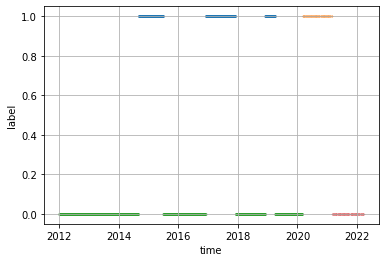

In [33]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(up_trading_dates_list_train, [1 for _ in range(len(up_trading_dates_list_train))], s=1)
plt.scatter(up_trading_dates_list_test, [1 for _ in range(len(up_trading_dates_list_test))], s=0.1)
plt.scatter(down_trading_dates_list_train, [0 for _ in range(len(down_trading_dates_list_train))], s=1)
plt.scatter(down_trading_dates_list_test, [0 for _ in range(len(down_trading_dates_list_test))], s=0.1)

plt.xlabel('time')
plt.ylabel('label')

plt.grid()


In [46]:
from my_utils.data_process import remove_st
from rqdatac import index_components, get_factor, get_price, is_suspended, get_next_trading_date, instruments, all_instruments
import time
import datetime
import numpy as np
import pandas as pd

time_begin = time.time()

for list_name in ['down_trading_dates_list_test', 'up_trading_dates_list_train', 'up_trading_dates_list_test', 'down_trading_dates_list_train']:

    print()
    print('list_name: {}'.format(list_name))
    trading_dates_list_interval = eval(list_name)

    df_plus = pd.DataFrame()

    for j in range(len(trading_dates_list_interval)):

        print()
        print("number of trading_dates_list_interval: {}/{}".format(j, len(trading_dates_list_interval)-1))
        print("use time: {}".format(time.time()-time_begin))

        date = trading_dates_list_interval[j]

        # 全部股票
        if para.index_code == 'CS':
            stocks_list = all_instruments(type=para.index_code, date=date)['order_book_id'].values.tolist()
        # hs300
        elif para.index_code == '000300.XSHG':
            stocks_list = index_components(order_book_id=para.index_code, date=date)
        # 个股
        else:
            stocks_list = [para.index_code]

        # 剔除 ST 股票
        stocks_list_no_st = remove_st(stocks_list=stocks_list, date=date)
        # 获取因子
        df = get_factor(order_book_ids=stocks_list_no_st, factor=para.factor_list, date=date)
        # 处理多级索引
        df = df.reset_index(level='date')
        # 插入 month 列
        df.insert(loc=0, column='month', value=j)
        # 插入收益率列
        df.insert(loc=0, column='yield_rate', value=np.nan)
        # 插入行业类别列
        df.insert(loc=0, column='sector_code', value=np.nan)
        # 插入板块类别列
        df.insert(loc=0, column='board_type', value=np.nan)

        # 遍历当前截面的每只股票
        for i in df.index.values.tolist():

            # 获取行业和板块信息
            df.loc[i, 'sector_code'] = instruments(order_book_ids=i).sector_code
            df.loc[i, 'board_type'] = instruments(order_book_ids=i).board_type

            # 获取当前日期和未来日期
            day = trading_dates_list_interval[df.loc[i, 'month']]
            day_interval = get_next_trading_date(date=day, n=para.yield_rate_interval)

            # 获取当前日期和未来日期停牌状态
            day_is_suspended = bool(is_suspended(order_book_ids=i, start_date=day, end_date=day).values[0][0])
            day_interval_is_suspended = bool(is_suspended(order_book_ids=i, start_date=day, end_date=day).values[0][0])

            # 判断是否停牌
            if day_is_suspended == False and day_interval_is_suspended == False:

                # 获取当前日期和未来日期的价格
                day_price = get_price(order_book_ids=i, start_date=day, end_date=day, fields='close')
                day_interval_price = get_price(order_book_ids=i, start_date=day_interval, end_date=day_interval, fields='close')

                # 判断是否数据缺失
                if day_price is None or day_interval_price is None:
                    print("day_price or day_interval_price is None: {}".format(i))
                else:
                    # 判断距离上市天数
                    listed_date = datetime.datetime.strptime(instruments(order_book_ids=i).listed_date, '%Y-%m-%d').date()
                    how_long_listed = (trading_dates_list_interval[j]-listed_date).days

                    if how_long_listed > 90:
                        yield_rate = day_interval_price['close'].item() / day_price['close'].item() - 1
                        df.loc[i, 'yield_rate'] = yield_rate
                    else:
                        print('how_long_listed <= 90d: {}'.format(i))

            else:
                print("day_is_suspended or day_interval_is_suspended == True: {}".format(i))

        # 拼接
        df_plus = pd.concat([df_plus, df], axis=0)

    # 数据预处理
    # Replace infinite updated data with nan
    df_plus.replace(to_replace=[np.inf, -np.inf], value=np.nan, inplace=True)

    # 剔除含有 na 的行
    df_dropna = df_plus.dropna(axis=0, how='any')

    # 选择特征列和标签列
    df_dropna_y = df_dropna[['board_type', 'sector_code', 'month', 'date']]
    df_dropna_features = df_dropna.loc[:, para.feature_column_start_name:para.feature_column_end_name]
    df_dropna_features = pd.concat([df_dropna['yield_rate'], df_dropna_features], axis=1)

    # 中位数去极值
    df_dropna_features = df_dropna_features.clip(
        lower=df_dropna_features.median(axis=0) - 5 * df_dropna_features.mad(axis=0),
        upper=df_dropna_features.median(axis=0) + 5 * df_dropna_features.mad(axis=0),
        axis=1)

    # 标准化
    df_dropna_features = (df_dropna_features - df_dropna_features.mean()) / df_dropna_features.std(ddof=0)

    # 拼接标签列和特征列
    df_dropna_standard = pd.concat([df_dropna_y, df_dropna_features], axis=1)

    # 写入文件
    if list_name == 'up_trading_dates_list_train':
        df_dropna_standard.to_csv(para.write_folder_path + 'up_train' + '/0.csv')
    elif list_name == 'up_trading_dates_list_test':
        df_dropna_standard.to_csv(para.write_folder_path + 'up_test' + '/0.csv')
    elif list_name == 'down_trading_dates_list_train':
        df_dropna_standard.to_csv(para.write_folder_path + 'down_train' + '/0.csv')
    elif list_name == 'down_trading_dates_list_test':
        df_dropna_standard.to_csv(para.write_folder_path + 'down_test' + '/0.csv')

print()
print('Done!')


list_name: down_trading_dates_list_test

number of trading_dates_list_interval: 0/257
use time: 0.000997304916381836

number of trading_dates_list_interval: 1/257
use time: 0.802255392074585

number of trading_dates_list_interval: 2/257
use time: 1.2221343517303467

number of trading_dates_list_interval: 3/257
use time: 1.6755778789520264

number of trading_dates_list_interval: 4/257
use time: 2.161177396774292

number of trading_dates_list_interval: 5/257
use time: 2.6287002563476562

number of trading_dates_list_interval: 6/257
use time: 3.0590946674346924

number of trading_dates_list_interval: 7/257
use time: 3.4245831966400146

number of trading_dates_list_interval: 8/257
use time: 3.8204774856567383

number of trading_dates_list_interval: 9/257
use time: 4.255441904067993

number of trading_dates_list_interval: 10/257
use time: 4.659204959869385

number of trading_dates_list_interval: 11/257
use time: 5.057882785797119

number of trading_dates_list_interval: 12/257
use time: 5.4

In [47]:
import winsound
winsound.Beep(1000, 3000)